# Third Homework - Lime

First descriptive part of this homework is provided in the form of pdf document.


##Part 2. Code

###Dependencies

In [1]:
!pip install dalex
!pip install lime
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.3 MB/s 
  Created wheel for dalex: filename=dalex-1.5.0-py3-none-any.whl size=1043321 sha256=07c4a9a4ef147e03773e585f3ed161ad25e4dda40474bd5957be7111fad4cf95
  Stored in directory: /root/.cache/pip/wheels/76/31/8c/c78df586df31b3f3e0c4ecc759ee73e175545cff5548201996
Successfully built dalex
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 5.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=2611b96c03ff31b99e6a444bae24b2c21e71f81bb92ce3e196c81b3aca58eae4
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█████████████████████

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import shap
import dalex as dx
import lime

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import random

###Downloading Dataset
Firstly, in order to download Alcohol Effects on Study dataset, we mount google drive and upload kaggle API.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import files

Mounted at /content/gdrive


In [4]:
files.upload() #this will prompt you to upload the kaggle.jso

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"paulinakaczyska","key":"a590f81fa200cd408d5cb174df96882a"}'}

In [5]:
#make sure kaggle.json file is present
!ls -lha kaggle.json

#Install kaggle API client
!pip install -q kaggle

#kaggle API client expects the file to be in ~/.kaggle

#so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#seting permissions
!chmod 600 /root/.kaggle/kaggle.json

#check your directory before downloading the datasets
!pwd

#downloading
!kaggle datasets download -d whenamancodes/alcohol-effects-on-study

#unzipping
!unzip alcohol-effects-on-study.zip

-rw-r--r-- 1 root root 71 Oct 26 07:01 kaggle.json
/content
  0% 0.00/18.1k [00:00<?, ?B/s]
100% 18.1k/18.1k [00:00<00:00, 15.4MB/s]
Archive:  alcohol-effects-on-study.zip
  inflating: Maths.csv               
  inflating: Portuguese.csv          


### Data Preprocessing

In [6]:
binary = ['school', 'sex', 'address', 'famsize', 'Pstatus','schoolsup', 'famsup', 'paid', 'activities', 'nursery','higher', 'internet', 'romantic']
categorical_nb = ['Mjob', 'Fjob', 'reason', 'guardian']
numerical = ['Medu', 'Fedu','traveltime', 'studytime','failures','famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

The categorical data are one-hot encoded. Data is divided to input and output.

In [7]:
math = pd.read_csv("Maths.csv", encoding = "UTF-8")
port = pd.read_csv("Portuguese.csv", encoding = "UTF-8")

math_i_c = pd.get_dummies(math[binary+categorical_nb],drop_first = True)
port_i_c = pd.get_dummies(port[binary+categorical_nb],drop_first = True)

math_o = math.iloc[:,-1]
port_o = port.iloc[:,-1]


In [8]:
math

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


Data is combined into input X and output Y arrays.

In [9]:

math_array = pd.concat([math_i_c,math[numerical]],axis=1)
port_array = pd.concat([port_i_c,port[numerical]],axis=1)
X = pd.concat((math_array,port_array),axis = 0).reset_index().drop(['index'],axis=1)
Y = pd.concat((math_o,port_o),axis = 0).reset_index().drop(['index'],axis=1)


Division for test and train dataset is made using train_test_split from sklearn library.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=100, train_size=len(X)-100)

###LIME method on Random Forest Regressor

Firstly, I train Random Forest Regression using function from sklearn package. This method is a tree ensemble method. 

In [11]:
model_rfr = RandomForestRegressor(n_estimators = 300, max_depth=4, random_state=0)
model_rfr.fit(X_train, y_train)

y_pred = model_rfr.predict(X_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


I select  observations from the dataset and calculate the model's prediction.


In [21]:
sample = random.sample(list(X.index),5)

X_sample = X.iloc[sample]
Y_sample = Y.iloc[sample]

Y_pred_sample = model_rfr.predict(X_sample)

In [35]:
print('Students predicted grades are:',Y_pred_sample,'and students numbers are:',sample)
print('Their true grades are:',Y_sample)

Students predicted grades are: [12.42452791 14.73422296  3.19824137 12.31118094 12.79961864] and students numbers are: [470, 198, 239, 73, 426]
Their true grades are:      G3
470  11
198  18
239   0
73   14
426  15


In [14]:

explainer_lime = dx.Explainer(model_rfr, X, Y)

Preparation of a new explainer is initiated

  -> data              : 1044 rows 38 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 1044 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fc5943283b0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 2.25, mean = 11.3, max = 14.8
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


  -> residuals         : min = -13.1, mean = 0.0296, max = 8.5
  -> model_info        : package sklearn

A new explainer has been created!


This is the function taking explainer and observation and returning observation's explanation:

In [15]:
def explain_obs(explainer, observation):
  explainer.predict(observation)
  explanation = explainer.predict_surrogate(observation)
  print(explanation.result)
  explanation.plot()

Student nr470
                    variable    effect
0           failures <= 0.00  3.954186
1           absences <= 0.00 -0.763398
2      schoolsup_yes <= 0.00  0.488574
3       Fjob_teacher <= 0.00 -0.351078
4           paid_yes <= 0.00  0.236544
5   1.00 < studytime <= 2.00 -0.174650
6     guardian_other <= 0.00  0.129421
7        3.00 < Medu <= 4.00  0.125187
8  reason_reputation <= 0.00 -0.119654
9   0.00 < address_U <= 1.00  0.103593
Student nr198
                    variable    effect
0            failures > 0.00 -4.031883
1      schoolsup_yes <= 0.00  0.516678
2        Fjob_teacher > 0.00  0.310740
3            absences > 6.00  0.303743
4       Mjob_teacher <= 0.00  0.217683
5           paid_yes <= 0.00  0.211751
6          studytime <= 1.00 -0.205498
7      Fjob_services <= 0.00 -0.145766
8        3.00 < Medu <= 4.00  0.137604
9  reason_reputation <= 0.00 -0.114712
Student nr239
                   variable    effect
0           failures > 0.00 -4.060904
1          absences <= 0

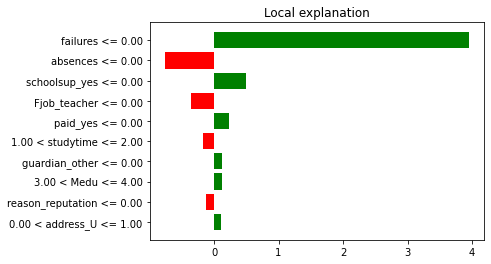

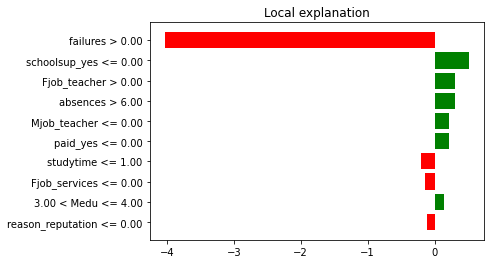

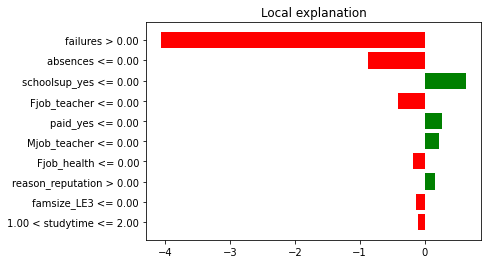

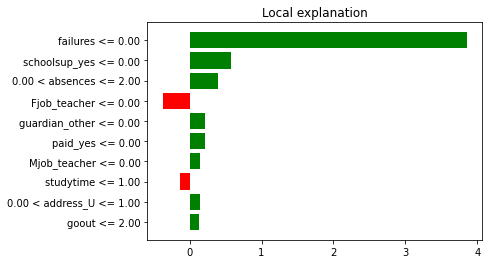

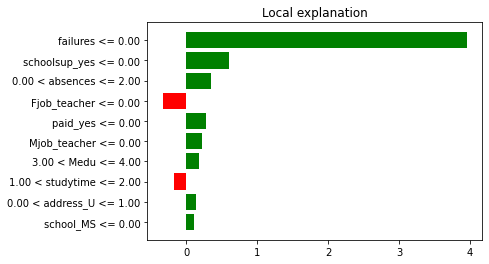

In [22]:
for i in sample:
  print('Student nr'+str(i))
  explain_obs(explainer_lime,X.iloc[[i]])

In all cases the number of failures is the most important feature. Absences and receiving schoolsupport are also on high positions. However, because of the randomness, the exact values for the same student are not the same when explanation is repeated, as can be seen for the first student in the sample:

                   variable    effect
0          failures <= 0.00  3.831773
1          absences <= 0.00 -0.688890
2     schoolsup_yes <= 0.00  0.556001
3      Fjob_teacher <= 0.00 -0.225799
4          paid_yes <= 0.00  0.220544
5  1.00 < studytime <= 2.00 -0.216415
6       3.00 < Medu <= 4.00  0.168060
7       1.00 < Dalc <= 2.00 -0.157820
8    guardian_other <= 0.00  0.150078
9  0.00 < address_U <= 1.00  0.093932


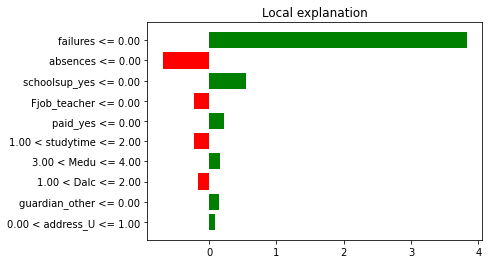

In [23]:
explain_obs(explainer_lime, X.iloc[[sample[0]]])

###SHAP on Random Forest Regressor

I calculate the decomposition of predictions for the students sampled above, using SHAP from dalex and shap.

In [24]:
# explain the model with SHAP
explainer_rfr_shap = shap.explainers.Tree(model_rfr, data=X)
shap_values_rfr = explainer_rfr_shap(X_sample)

This are the waterfall plots for the students using shap:

Explanation for student nr470grade prediction


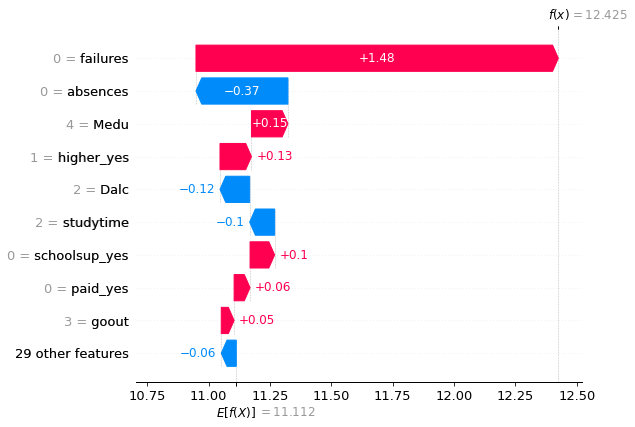

Explanation for student nr198grade prediction


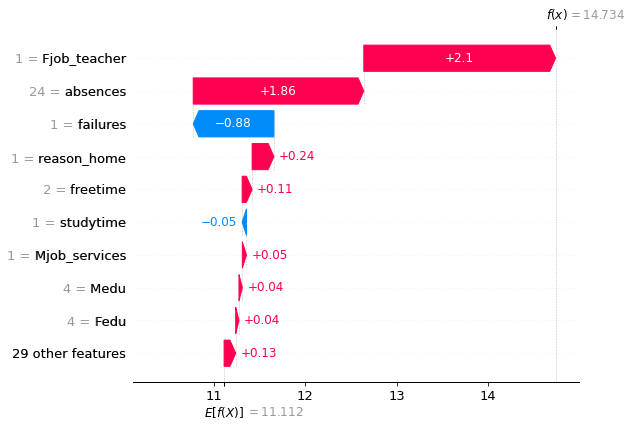

Explanation for student nr239grade prediction


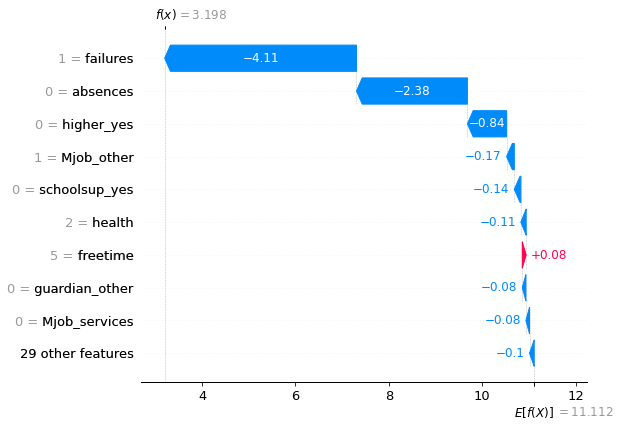

Explanation for student nr73grade prediction


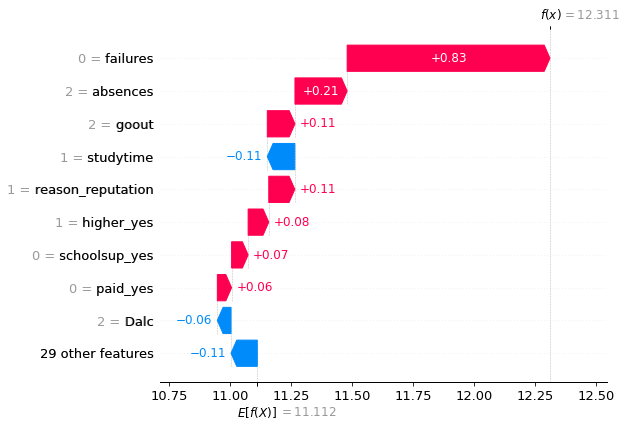

Explanation for student nr426grade prediction


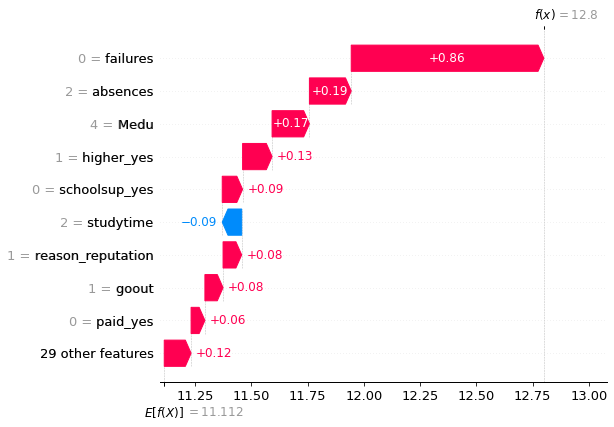

In [25]:
for i in range(5):
  print('Explanation for student nr'+str(sample[i])+'grade prediction')
  shap.plots.waterfall(shap_values_rfr[i])

The explanations differ in shap and lime. For example student nr 198 has the different feature with the biggest contribution to the explanation in both methods: failures in lime and father working as a teacher in shap. I would propose a hypothesis, that lime is more often proposing the feature that is most important in other observations.




###LIME on Linear Regression

In [26]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [27]:
explainer_lime_lr = dx.Explainer(model_lr,X)


Preparation of a new explainer is initiated

  -> data              : 1044 rows 38 cols
  -> target variable   : Not specified!
  -> model_class       : sklearn.linear_model._base.LinearRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fc5943283b0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 3.22, mean = 11.3, max = 15.4
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> model_info        : package sklearn

A new explainer has been created!


X does not have valid feature names, but LinearRegression was fitted with feature names

  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)


Studnet No. 470
                   variable    effect
0          failures <= 0.00  2.750153
1     schoolsup_yes <= 0.00  1.237172
2          paid_yes <= 0.00  1.083939
3      Fjob_teacher <= 0.00 -1.006147
4       Mjob_health <= 0.00 -0.949828
5      romantic_yes <= 0.00  0.589474
6    guardian_other <= 0.00 -0.497312
7     Fjob_services <= 0.00  0.481367
8  0.00 < address_U <= 1.00  0.394074
9     4.00 < health <= 5.00 -0.379626
Studnet No. 198
                 variable    effect
0         failures > 0.00 -2.840360
1   schoolsup_yes <= 0.00  1.248346
2        paid_yes <= 0.00  1.135546
3       studytime <= 1.00 -1.010759
4     Fjob_teacher > 0.00  0.954011
5     Mjob_health <= 0.00 -0.906433
6    romantic_yes <= 0.00  0.635963
7  guardian_other <= 0.00 -0.472315
8   Fjob_services <= 0.00  0.455301
9    Mjob_services > 0.00  0.449101
Studnet No. 239
                       variable    effect
0               failures > 0.00 -2.740739
1         schoolsup_yes <= 0.00  1.266200
2           

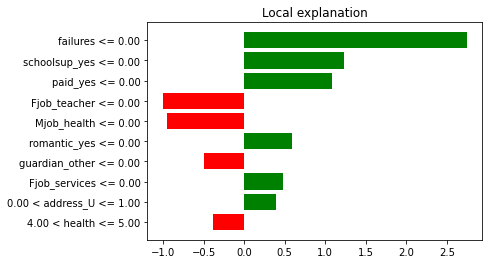

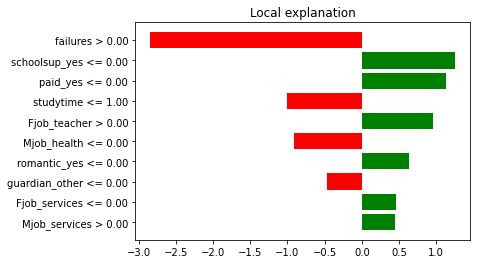

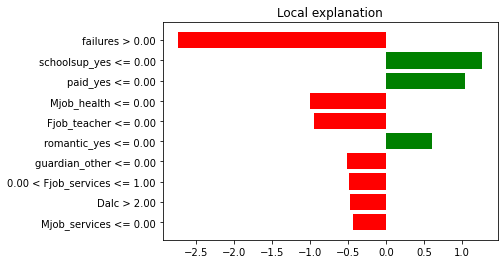

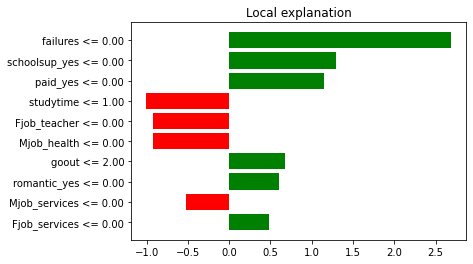

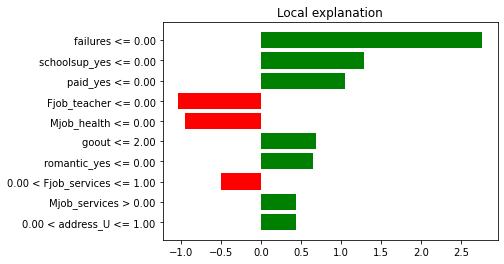

In [32]:
for i in sample:
  print('Studnet No. '+str(i))
  explain_obs(explainer_lime_lr, X.iloc[[i]])

The values for features other than the most important are higher for the linear regression that the random forest regression. It was similar with the SHAP method. Explanations also favour features more important in other observations. 